In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import itertools
from collections import OrderedDict
from tqdm import tqdm_notebook, tqdm
from scipy import stats

%matplotlib inline

# Most Influential Artists (Highest Out-Degree in AllMusic Graph)

In [2]:
# Load artist information
artists = pd.read_csv('data/allmusic/artists.txt', header=None, names=['name', 'url', 'active_period', 'genres', 'styles'])
# Load influence relationships
influences = pd.read_csv('data/allmusic/influences.txt', header=None, names=['influencer_name', 'influencer_url', 'follower_name', 'follower_url'])

In [3]:
# Create directed graph from influence relationships
G = nx.DiGraph()

for row in influences.itertuples():
    G.add_edge(row.influencer_name, row.follower_name)

In [40]:
# Summary of AllMusic Graph
print nx.info(G)

Name: 
Type: DiGraph
Number of nodes: 15049
Number of edges: 83143
Average in degree:   5.5248
Average out degree:   5.5248


In [4]:
# Find nodes with highest outdegree
outdegree_dict = G.out_degree()
# Display 100 most influential artists
sorted(outdegree_dict.items(), key=lambda x: x[1], reverse=True)[:100]

[('The Beatles', 829),
 ('Bob Dylan', 540),
 ('The Rolling Stones', 427),
 ('David Bowie', 317),
 ('The Velvet Underground', 314),
 ('The Kinks', 294),
 ('The Beach Boys', 282),
 ('Jimi Hendrix', 281),
 ('Neil Young', 254),
 ('James Brown', 251),
 ('The Byrds', 247),
 ('Led Zeppelin', 246),
 ('Hank Williams', 238),
 ('Miles Davis', 234),
 ('John Coltrane', 222),
 ('Brian Eno', 215),
 ('Black Sabbath', 213),
 ('Elvis Presley', 212),
 ('Chuck Berry', 204),
 ('The Who', 203),
 ('Pink Floyd', 197),
 ('Kraftwerk', 189),
 ('The Clash', 189),
 ('The Stooges', 189),
 ('Sex Pistols', 187),
 ('Marvin Gaye', 186),
 ('Sonic Youth', 186),
 ('Stevie Wonder', 180),
 ('Muddy Waters', 171),
 ('Ramones', 167),
 ('Johnny Cash', 163),
 ('Duke Ellington', 161),
 ('Louis Armstrong', 149),
 ('Nirvana', 146),
 ('Sam Cooke', 146),
 ('Charlie Parker', 146),
 ('Joni Mitchell', 146),
 ('Prince', 140),
 ('Black Flag', 135),
 ('Metallica', 135),
 ('Leonard Cohen', 134),
 ('R.E.M.', 132),
 ('Roxy Music', 132),
 ('Bi

In [88]:
# Write Gephi file for visualization
nx.write_edgelist(G, 'all_influence.gexf')

In [11]:
# Get list of all artists from Allmusic
allmusic_artists = pd.unique(artists['name'])

# SecondHandSongs Covers

In [5]:
# Load data
covers = pd.read_csv('data/secondhandsongs/covers.csv')

In [4]:
covers.head()

,work_id,work,adapted_work_id,adapted_work,performance_id,performance,performer_id,performer,artist_ids,artists,release_date,performance_date
0,1,Petite fleur,1,Petite fleur,1,Petite fleur,1.0,Sidney Bechet,1,Sidney Bechet,1952,1952-01-21
1,1,Petite fleur,1,Petite fleur,2,Petite fleur,3.0,Chris Barber's Jazz Band,113638,Chris Barber Band,1959,NaN
2,1,Petite fleur,1,Petite fleur,39127,Petite fleur,494.0,Charlie Byrd,494,Charlie Byrd,2000-03-14,NaN
3,1,Petite fleur,1,Petite fleur,40915,Petite fleur,12897.0,Laurindo Almeida & The Bossa Nova Allstars,12898,Laurindo Almeida,1962,NaN
4,1,Petite fleur,1,Petite fleur,66022,Petite fleur,27422.0,"Bart Voet, Louis Debij, Sam Vloemans, Esmé Bos...","31845, 31849, 31846, 31847, 31848","Bart Voet, Gulli Gudmundsson, Louis Debij, Sam...",2001,NaN


In [6]:
# Drop any rows with missing performer, release_date, artists
covers = covers.dropna(subset=['release_date', 'performer', 'artists'])

In [7]:
# Basic summary statistics for number of covers
covers.groupby('adapted_work_id').count()['work'].describe()

count    86827.00000
mean         7.42610
std         25.23396
min          1.00000
25%          2.00000
50%          2.00000
75%          5.00000
max       2004.00000
Name: work, dtype: float64

## What percentage of AllMusic artists are covered by artists in SecondHandSongs?
Note that this is using exact string matching

In [51]:
# Get a list of all unique artists from SecondHandSongs
shs_artists = []

for artist_string in tqdm(covers['artists'].dropna().tolist()):
    # Sometimes there are multiple artists, so split on comma
    try:
        artists = [artist.strip() for artist in artist_string.split(',')]
    except:
        print artist_string
    
    for artist in artists:
        if artist not in shs_artists:
            shs_artists.append(artist)


100%|██████████| 644786/644786 [02:43<00:00, 3940.18it/s]


In [52]:
shared_artist_count = 0

for am_artist in allmusic_artists:
    if am_artist in shs_artists:
        shared_artist_count += 1
    
print "Percentage of Allmusic artists in SHS artists:", shared_artist_count / float(len(allmusic_artists))
print "Number of Allmusic artists", len(allmusic_artists)
print "Number of SHS artists", len(shs_artists)
# TODO: Perhaps account for unicode escaping issue?

Percentage of Allmusic artists in SHS artists: 0.584826804562
Number of Allmusic artists 14117
Number of SHS artists 77328


# Build up a network based on cover songs

In [8]:
# Group by work id, sorting by year within each group
grouped_by_id = covers.sort_values('release_date').groupby('work_id')

In [9]:
grouped_by_id.get_group(1)

,work_id,work,adapted_work_id,adapted_work,performance_id,performance,performer_id,performer,artist_ids,artists,release_date,performance_date
0,1,Petite fleur,1,Petite fleur,1,Petite fleur,1.0,Sidney Bechet,1,Sidney Bechet,1952,1952-01-21
38,1,Petite fleur,1,Petite fleur,404001,Petit fleur,66252.0,Owen Bradley,32386,Owen Bradley,1958,NaN
1,1,Petite fleur,1,Petite fleur,2,Petite fleur,3.0,Chris Barber's Jazz Band,113638,Chris Barber Band,1959,NaN
45,1,Petite fleur,1,Petite fleur,523809,Tom Dooley - Patricia - Petite Fleur,116901.0,Hans-Arno Simon und sein Cocktail-Piano,105244,Hans-Arno Simon,1959,NaN
48,1,Petite fleur,1,Petite fleur,536140,Petite fleur,119510.0,Trumpet Boy et sa trompette-succès,107213,Trumpet Boy,1959,NaN
63,1,Petite fleur,117024,Petite fleur,148970,Petite fleur,14424.0,Henri Salvador,14424,Henri Salvador,1959,NaN
41,1,Petite fleur,1,Petite fleur,414930,Petite fleur,99807.0,Woody Herman Sextet,11276,Woody Herman,1959,1959-01-26
54,1,Petite fleur,1,Petite fleur,559115,Petit fleur,102348.0,Mats Olsson,85516,Mats Olsson,1959,NaN
12,1,Petite fleur,1,Petite fleur,174586,Petite fleur,52264.0,Jacques Leroy and His Orchestra,53821,Jacques Leroy,1959-02,NaN
61,1,Petite fleur,57628,可愛い花 [Petite fleur],57628,可愛い花 [Petite fleur],24964.0,ザ・ピーナッツ,25674,The Peanuts,1959-04,NaN


In [80]:
# Create graph from cover songs, drawing directed edge from each person in the cover chain
# to the next artist that covered the song chronologically
cover_graph = nx.DiGraph()

for song, song_cover_df in tqdm(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
        if i < len(artists_series) - 1:
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[i + 1].split(', ')
            
            for current_artist in current_artists:
                for succesor_artist in successor_artists:
                    cover_graph.add_edge(current_artist, succesor_artist)


100%|██████████| 87118/87118 [00:28<00:00, 3109.77it/s]

In [85]:
nx.write_gexf(cover_graph, 'covers.gexf')

In [94]:
print nx.info(cover_graph)
print "Number weakly connected components:", nx.number_weakly_connected_components(cover_graph)

 Name: 
Type: DiGraph
Number of nodes: 76889
Number of edges: 681737
Average in degree:   8.8665
Average out degree:   8.8665
Number weakly connected components: 169


In [95]:
# Find nodes with highest outdegree
cover_outdegree_dict = cover_graph.out_degree()
# Display 100 most influential artists
sorted(cover_outdegree_dict.items(), key=lambda x: x[1], reverse=True)[:100]

[('Top of the Pops', 851),
 ('Ella Fitzgerald', 607),
 ('Frank Sinatra', 598),
 ('Willie Nelson', 589),
 ('Elvis Presley', 557),
 ('Johnny Mathis', 529),
 ('Ray Conniff', 525),
 ('Tony Bennett', 489),
 ('Geoff Love', 485),
 ('Bing Crosby', 466),
 ('Oscar Peterson', 458),
 ('Sarah Vaughan', 456),
 ('Peggy Lee', 447),
 ('Cliff Richard', 439),
 ('Johnny Cash', 436),
 ('Ray Brown', 435),
 ('George Shearing', 430),
 ('James Last', 416),
 ('Mel Torm\xc3\xa9', 415),
 ('Rosemary Clooney', 410),
 ('The Jordanaires', 404),
 ('Andy Williams', 402),
 ('John Pizzarelli', 392),
 ('Bucky Pizzarelli', 389),
 ('Bob Dylan', 388),
 ('Kenny Barron', 384),
 ('Hank Jones', 383),
 ('Jerry Lee Lewis', 374),
 ('Joe Pass', 372),
 ('St\xc3\xa9phane Grappelli', 369),
 ('Percy Faith', 367),
 ('Nancy Wilson', 363),
 ('Carmen McRae', 362),
 ('Dave McKenna', 358),
 ('Pat Boone', 356),
 ('Connie Francis', 353),
 ('Eddy Arnold', 350),
 ('Chet Atkins', 350),
 ('Vitamin String Quartet', 349),
 ('Keith Ingham', 346),
 ('S

# Most Covered Songs

In [103]:
# Sort groups of covers by number of covers in each group in descending order
grouped_by_id_sorted = sorted(grouped_by_id, key=lambda x: len(x[1]), reverse=True)

In [118]:
# Print top 25 most covered songs with their count of samples
for i in range(25):
    print grouped_by_id_sorted[i][1]['work'].iloc[0], grouped_by_id_sorted[i][1]['work'].count()

Summertime 1633
Stille Nacht! Heilige Nacht! 1614
Silent Night! Holy Night! 1002
Minuit, chrétiens 940
A New Northern Dittye of the Lady Greene Sleeves 907
White Christmas 875
Have Yourself a Merry Little Christmas 828
The Christmas Song (Merry Christmas to You) 772
Over the Rainbow 719
Body and Soul 710
Adeste fideles 695
O, Holy Night 652
Jingle Bells 633
Winter Wonderland 629
Luther's Cradle Hymn 627
Cradle Song 626
Les feuilles mortes 624
God Rest You Merry, Gentlemen 613
The First Nowell the Angel Did Say 607
My Funny Valentine 582
Yesterday 573
Carol of the Drum 555
I'll Be Home for Christmas (If Only in My Dreams) 540
Joy to the World 532
St. Louis Blues 524


In [119]:
grouped_by_id_sorted[i][1]

,work_id,work,adapted_work_id,adapted_work,performance_id,performance,performer_id,performer,artist_ids,artists,release_date,performance_date,release_datetime
51374,3599,St. Louis Blues,3599,St. Louis Blues,138244,St. Louis Blues,44302.0,Ciro's Club Coon Orchestra,46333,Ciro's Club Coon Orchestra,1916,1916-09,None
51307,3599,St. Louis Blues,3599,St. Louis Blues,3599,St. Louis Blues,25679.0,Prince's Band,26565,Prince's Band,1916,1916-01-03,None
51511,3599,St. Louis Blues,3599,St. Louis Blues,140477,Saint Louis Blues,35037.0,Ernest Hare,37033,Ernest Hare,1919,1919-01,None
51628,3599,St. Louis Blues,3599,St. Louis Blues,261656,St. Louis Blues,70316.0,"Lt. Jim Europe's 369th Infantry ""Hell Fighters...",69873,Jim Europe,1919,1919-02,None
51762,3599,St. Louis Blues,3599,St. Louis Blues,460380,The St. Louis Blues,106059.0,Wadsworth's Novelty Dance Orchestra,52680,Wadsworth's Novelty Dance Orchestra,1919,1918-11,None
51313,3599,St. Louis Blues,3599,St. Louis Blues,40914,St. Louis Blues,7894.0,Marion Harris,7894,Marion Harris,1920,NaN,None
51490,3599,St. Louis Blues,3599,St. Louis Blues,140377,St. Louis Blues,44867.0,Al Bernard,46878,Al Bernard,1921,1920-12,None
51444,3599,St. Louis Blues,3599,St. Louis Blues,139191,St. Louis Blues,35676.0,Original Dixieland Jazz Band,27513,Original Dixieland Jazz Band,1921,1921-05-25,None
51750,3599,St. Louis Blues,3599,St. Louis Blues,452841,The St. Louis Blues,105124.0,Esther Bigeou,97228,Esther Bigeou,1921,1921-10-05,None
51560,3599,St. Louis Blues,3599,St. Louis Blues,206549,St. Louis Blues,58912.0,Lanin's Southern Serenaders,19880,Sam Lanin,1921,NaN,None


In [159]:
# Plot cumulative number of covers over time of an input series of release dates
def plot_covers_by_year(dates_series, title):
    # Extract year
    list_of_dates = dates_series.map(lambda x: int(x.split('-')[0]))
    counts = np.arange(0, len(list_of_dates))
    plt.plot(list_of_dates, counts)
    try:
        plt.title(title)
    except:
        pass
    plt.xlabel('Year')
    plt.ylabel('Total Number of Covers')
    plt.show()

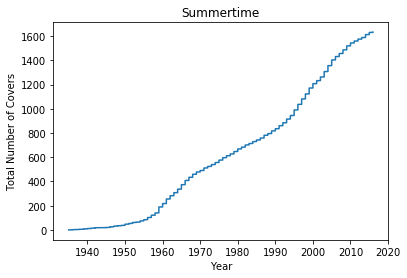

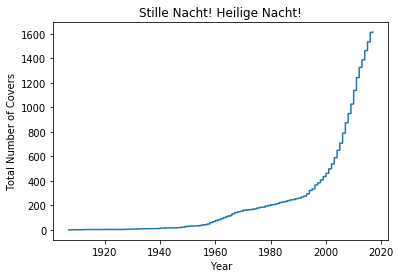

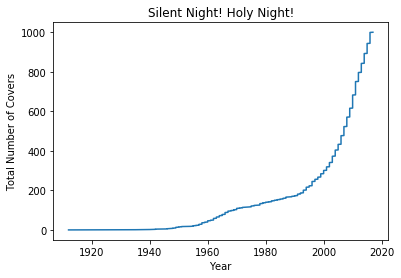

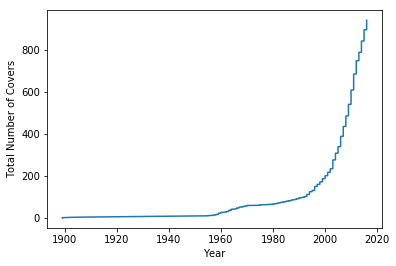

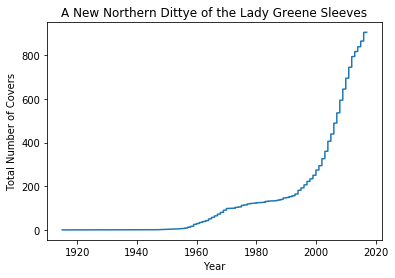

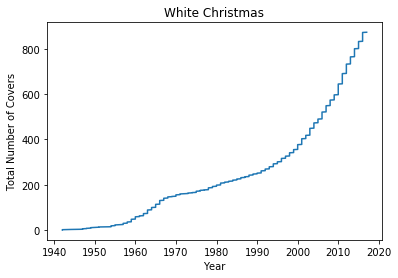

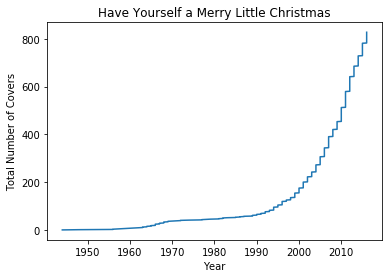

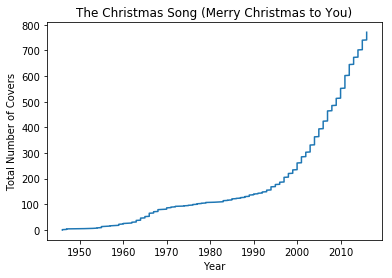

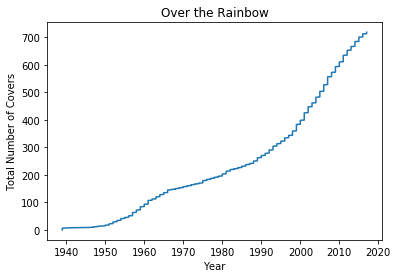

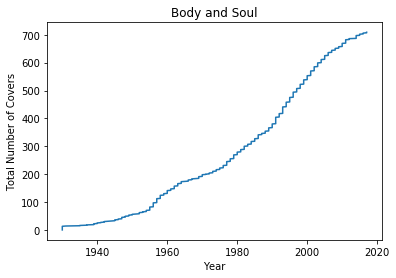

In [160]:
# Plot number of covers by year for top 10 most covered songs
for i in range(10):
    plot_covers_by_year(grouped_by_id_sorted[i][1]['release_date'], grouped_by_id_sorted[i][1]['work'].iloc[0])

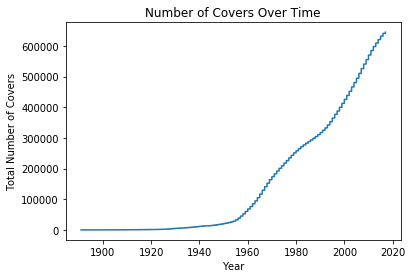

In [163]:
# Plot number of covers by year over all songs
plot_covers_by_year(covers.sort_values('release_date')['release_date'], "Number of Covers Over Time")

# Most Covered Artists

In [185]:
# Return counts per artist of number of songs where they were the original artist
Counter(grouped_by_id.first()['performer']).most_common()

# TODO: Overlap with AllMusic

[('ApologetiX', 308),
 ('Bob Dylan', 223),
 ('Claude Fran\xc3\xa7ois', 186),
 ('Johnny Hallyday', 159),
 ('David Bowie', 148),
 ('Bruce Springsteen', 144),
 ('Tom Waits', 143),
 ('Raga Rockers', 137),
 ('Dalida', 136),
 ('Eddy Mitchell', 135),
 ('Richard Anthony', 133),
 ('Will Tura', 130),
 ('Ramones', 127),
 ('Elvis Presley with The Jordanaires', 122),
 ('Benny Neyman', 119),
 ('Depeche Mode', 117),
 ('Peter Belli', 115),
 ('Stevie Wonder', 114),
 ('The Kinks', 113),
 ('The Beach Boys', 105),
 ('Elvis Presley', 105),
 ('Pink Floyd', 104),
 ('Kiss', 97),
 ('The Beatles', 96),
 ('The Rolling Stones', 95),
 ('Joe Dassin', 94),
 ('Die Schl\xc3\xbcmpfe', 93),
 ('Joni Mitchell', 93),
 ('Genesis', 92),
 ('The Who', 90),
 ('Johnny Cash', 90),
 ('Jacques Brel', 89),
 ('Vazelina Bilopph\xc3\xb8ggers', 85),
 ('Danny', 83),
 ('Fabrizio De Andr\xc3\xa9', 83),
 ('Sylvie Vartan', 82),
 ('The Cure', 81),
 ('Jimmie Rodgers', 81),
 ('De La Soul', 81),
 ('Petula Clark', 80),
 ('Nana Mouskouri', 79),
 (

In [203]:
G.nodes()

['Everette Harp',
 'Tommy Conwell',
 'Franky Perez',
 'SayWeCanFly',
 'Killers',
 'Apologetix',
 'Peter Sarstedt',
 'Jake E. Lee',
 'Flo & Eddie',
 'Caifanes',
 'Loud Family',
 'S.O.D.',
 'Bunky Green',
 'Dierks Bentley',
 'Sam Amidon',
 'Prong',
 'Howard Fishman',
 'Foundation',
 'Tiles',
 'Twin Bandit',
 'Neil Young & Crazy Horse',
 'Boom Bap Project',
 'Dan Croll',
 'Luke Slater',
 'Kendra Smith',
 'Iron and Wine',
 'SPK',
 'Fred Anderson',
 'Florence Dore',
 'Bikini Kill',
 'T. Texas Tyler',
 'NDV',
 'Martha Redbone',
 'Blackgirl',
 'Mark Walker',
 'The Scene Is Now',
 'Lighter Shade of Brown',
 'Eddy Arnold',
 'Long John Baldry',
 'The Hidden Cameras',
 'Andrea Marcovicci',
 'Ralph Carney',
 'Tahiti 80',
 'Heights',
 'Josef K',
 'Youth Code',
 'Steve Hofstetter',
 'Steve Cropper',
 'Kirk Whalum',
 'Alberta Cross',
 'The Wake',
 'Hecate Enthroned',
 'Scruffs',
 'Teddy Riley',
 'Larsen',
 'Rocketship',
 'A Wilhelm Scream',
 'B2K',
 'Zero Hour',
 'Twisted Sister',
 'Slushii',
 'Peter

# TODO: See how number of covers breaks down by genre

# Distribution of Time in Years Between Covers

In [165]:
# List of year gaps between covers
year_gaps = []

for song, song_cover_df in tqdm(grouped_by_id):
    dates = song_cover_df['release_date'].tolist()
    
    for i, date in enumerate(dates):
        if i < len(dates) - 1:
            year_gaps.append(int(dates[i+1].split('-')[0]) - int(dates[i].split('-')[0]))

100%|██████████| 87118/87118 [00:21<00:00, 3998.99it/s]


In [175]:
pd.Series(year_gaps).describe()

count    557668.000000
mean          3.228173
std           7.084602
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         104.000000
dtype: float64

# Overlap Between SecondHandSongs and AllMusic Edges
Note: For overlap analysis, we draw directed edges between every ancestor in a sequence of cover versions and later versions.

In [29]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[j].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage:", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage: 0.176418940861
Number in overlap: 14668
Number missed: 68475


In [36]:
# Compute number of times an ancestral relationship in the cover songs dataset is found 
# in the AllMusic Influence Graph (Duplicates allowed)
overlap_count_with_duplicates = 0
total_count = 0
# Create counter for ancestral relationships, keyed by edge
ancestry_counter = Counter()

allmusic_edges = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[j].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges:
                        ancestry_counter[(current_artist, successor_artist)] += 1
                        overlap_count_with_duplicates +=1
                        
                    total_count += 1

print "Number of hits on AllMusic edges (Duplicates Allowed):", overlap_count_with_duplicates

A Jupyter Widget


Number of hits on AllMusic edges (Duplicates Allowed): 82558


In [ ]:
# Print ancestry relationships from cover songs also in AllMusic graph in decreasing order of number of occurrences
sorted(ancestry_counter.items(), key=lambda x: x[1], reverse=True)

## Weaker Assumption: Overlap when we only consider the parent in cover chain

In [37]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
        if i < len(artists_series) - 1:
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[i + 1].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage (immediate parent in cover chain only):", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage (immediate parent in cover chain only): 0.0354930661631
Number in overlap: 2951
Number missed: 80192


## Weaker Assumption: Overlap when we only consider the first song in the chain as a possible parent

In [39]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[0].split(', ')
            successor_artists = artists_series[i].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage (only first artist is parent):", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage (only first artist is parent): 0.0777094884717
Number in overlap: 6461
Number missed: 76682
